In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import hyperopt
import sys
sys.path.append('../spock/')
from modelfitting import train_test_split, ROC_curve, stable_unstable_hist, calibration_plot, unstable_error_fraction
try:
    plt.style.use('paper')
except:
    pass
%matplotlib inline

In [11]:
datapath = '../training_data/'
dset = 'resonant/'
Norbits = 1e4
Nout = 80
featureargs = (Norbits, Nout) # params to pass feature function
featurefolder = 'featuresNorbits{0:.1f}Nout{1}trio/'.format(Norbits, Nout)
trainingdatafolder = datapath+dset+featurefolder
print(trainingdatafolder)

../training_data/resonant/featuresNorbits10000.0Nout80trio/


In [38]:
space ={'max_depth': hp.qloguniform('x_max_depth', np.log(5), np.log(20), 1),
        'min_child_weight': hp.loguniform('x_min_child', 0, np.log(20)),
        'subsample': hp.uniform ('x_subsample', 0.8, 1),
}

def objective(params):
    clf = XGBClassifier(n_jobs=16, n_estimators = 50,
                            max_depth = int(params['max_depth']), 
                            min_child_weight = params['min_child_weight'],
                            subsample = params['subsample'],
                            learning_rate = 0.15, seed = 0)
    
    score = xgb.cv(clf.get_xgb_params(), dtrain, nfold = 5, metrics = "auc", early_stopping_rounds=10)
    avg_score =  np.mean(score["test-auc-mean"])
    error = np.mean(score["test-auc-std"])
    
    print("SCORE:", avg_score, "ERROR", error)#, "HOLDOUT SCORE", test_score)
    return{'loss':1-avg_score, 'status': STATUS_OK, "cv_score":avg_score , "cv_error":error}

In [51]:
near = ['EMcrossnear', 'EMfracstdnear', 'EPstdnear', 'MMRstrengthnear']
far = ['EMcrossfar', 'EMfracstdfar', 'EPstdfar', 'MMRstrengthfar']
megno = ['MEGNO', 'MEGNOstd']

features = near + far + megno

trainX, trainY, testX, testY = train_test_split(trainingdatafolder, features, filter=True)

dtrain = xgb.DMatrix(trainX, trainY)
dtest = xgb.DMatrix(testX, testY)


/mnt/ssd/miniconda3/envs/yba/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [49]:
print(trainY)

0        False
1         True
2         True
3        False
4        False
         ...  
90829    False
90830    False
90831    False
90832    False
90833    False
Name: Stable, Length: 90834, dtype: bool


In [52]:
%%time
trials = Trials()
import time
start = time.time()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 100, trials = trials, rstate=np.random.RandomState(seed=0))
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE:                                                                                                                          
0.9301673600000001                                                                                                              
ERROR                                                                                                                           
0.0013802380269272135                                                                                                           
SCORE:                                                                                                                          
0.9297235200000001                                                                                                              
ERROR                                                                                                                           
0.0018309077337537022                                                                            

ERROR                                                                                                                           
0.0014204500480094234                                                                                                           
SCORE:                                                                                                                          
0.9296540600000001                                                                                                              
ERROR                                                                                                                           
0.0016586517164360192                                                                                                           
SCORE:                                                                                                                          
0.93032138                                                                                       

SCORE:                                                                                                                          
0.9275560199999999                                                                                                              
ERROR                                                                                                                           
0.001799323273793446                                                                                                            
SCORE:                                                                                                                          
0.91376404                                                                                                                      
ERROR                                                                                                                           
0.0016795726235112468                                                                            

ERROR                                                                                                                           
0.0018966288737631367                                                                                                           
SCORE:                                                                                                                          
0.93017144                                                                                                                      
ERROR                                                                                                                           
0.0014406743798425134                                                                                                           
SCORE:                                                                                                                          
0.9306266400000001                                                                               

# max_depth controls depth of trees

12 lets the model use all the features and improvements seem minor beyond that

Text(0, 0.5, 'CV AUC')

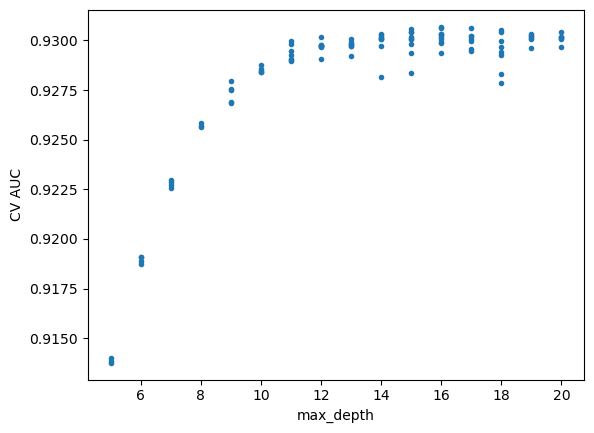

In [53]:
depths = trials.vals['x_max_depth']
min_childs = trials.vals['x_min_child']
aucs = np.array([1-x['loss'] for x in trials.results])

fig, ax = plt.subplots()
ax.plot(depths, aucs, '.')
ax.set_xlabel('max_depth')
ax.set_ylabel('CV AUC')

# min child weight acts as a regularizer, penalizing complex models. Larger min_child_weight = larger penalization

Text(0, 0.5, 'CV AUC')

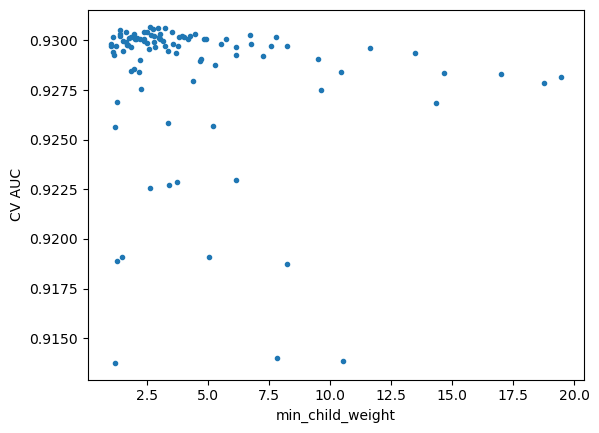

In [54]:
fig, ax = plt.subplots()
ax.plot(min_childs, aucs, '.')
ax.set_xlabel('min_child_weight')
ax.set_ylabel('CV AUC')

Text(0, 0.5, 'min_child_weight')

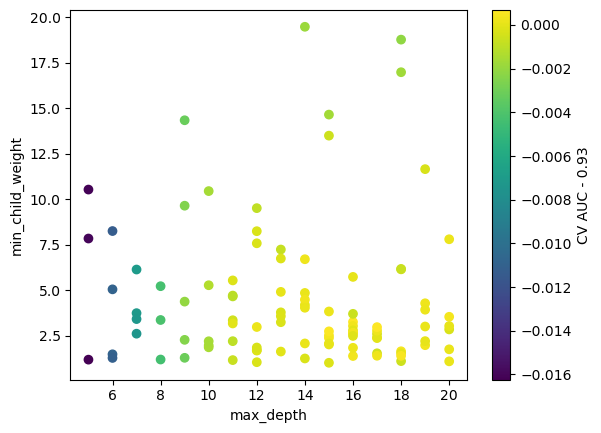

In [55]:
fig, ax = plt.subplots()
cb = ax.scatter(depths, min_childs, c=aucs-0.93)
plt.colorbar(cb, label='CV AUC - 0.93')
ax.set_xlabel('max_depth')
ax.set_ylabel('min_child_weight')

# Marginal improvements beyond max_depth of 13, so choose the least complex model

In [65]:
model = XGBClassifier(learning_rate = 0.03, 
                         max_depth = 20, 
                         subsample = 0.95,
                         min_child_weight = 5)

score = xgb.cv(model.get_xgb_params(), dtrain, nfold = 5, metrics = "auc", verbose_eval=True, num_boost_round=400)

[0]	train-auc:0.94552+0.00068	test-auc:0.91431+0.00167
[1]	train-auc:0.95406+0.00058	test-auc:0.92289+0.00183
[2]	train-auc:0.95735+0.00065	test-auc:0.92577+0.00187
[3]	train-auc:0.95930+0.00080	test-auc:0.92751+0.00180
[4]	train-auc:0.96068+0.00100	test-auc:0.92869+0.00179
[5]	train-auc:0.96174+0.00076	test-auc:0.92938+0.00188
[6]	train-auc:0.96275+0.00085	test-auc:0.93014+0.00175
[7]	train-auc:0.96341+0.00098	test-auc:0.93076+0.00191
[8]	train-auc:0.96410+0.00090	test-auc:0.93133+0.00179
[9]	train-auc:0.96486+0.00098	test-auc:0.93171+0.00167
[10]	train-auc:0.96546+0.00090	test-auc:0.93206+0.00166
[11]	train-auc:0.96635+0.00103	test-auc:0.93261+0.00159
[12]	train-auc:0.96694+0.00111	test-auc:0.93298+0.00176
[13]	train-auc:0.96738+0.00107	test-auc:0.93328+0.00168
[14]	train-auc:0.96801+0.00094	test-auc:0.93362+0.00160
[15]	train-auc:0.96870+0.00093	test-auc:0.93407+0.00172
[16]	train-auc:0.96924+0.00083	test-auc:0.93439+0.00169
[17]	train-auc:0.96976+0.00089	test-auc:0.93465+0.00161
[1

[146]	train-auc:0.99433+0.00017	test-auc:0.94738+0.00124
[147]	train-auc:0.99438+0.00017	test-auc:0.94740+0.00126
[148]	train-auc:0.99445+0.00017	test-auc:0.94747+0.00125
[149]	train-auc:0.99451+0.00016	test-auc:0.94751+0.00126
[150]	train-auc:0.99457+0.00017	test-auc:0.94754+0.00125
[151]	train-auc:0.99463+0.00017	test-auc:0.94758+0.00123
[152]	train-auc:0.99468+0.00017	test-auc:0.94760+0.00125
[153]	train-auc:0.99475+0.00017	test-auc:0.94763+0.00124
[154]	train-auc:0.99481+0.00017	test-auc:0.94767+0.00125
[155]	train-auc:0.99487+0.00018	test-auc:0.94772+0.00123
[156]	train-auc:0.99493+0.00018	test-auc:0.94776+0.00122
[157]	train-auc:0.99499+0.00019	test-auc:0.94782+0.00124
[158]	train-auc:0.99504+0.00018	test-auc:0.94785+0.00125
[159]	train-auc:0.99510+0.00019	test-auc:0.94787+0.00125
[160]	train-auc:0.99515+0.00021	test-auc:0.94790+0.00126
[161]	train-auc:0.99520+0.00020	test-auc:0.94793+0.00125
[162]	train-auc:0.99526+0.00020	test-auc:0.94796+0.00125
[163]	train-auc:0.99533+0.00019

[290]	train-auc:0.99859+0.00019	test-auc:0.95034+0.00121
[291]	train-auc:0.99861+0.00019	test-auc:0.95036+0.00121
[292]	train-auc:0.99861+0.00019	test-auc:0.95036+0.00121
[293]	train-auc:0.99863+0.00019	test-auc:0.95037+0.00122
[294]	train-auc:0.99864+0.00019	test-auc:0.95040+0.00124
[295]	train-auc:0.99866+0.00019	test-auc:0.95041+0.00124
[296]	train-auc:0.99867+0.00019	test-auc:0.95042+0.00124
[297]	train-auc:0.99868+0.00019	test-auc:0.95043+0.00124
[298]	train-auc:0.99870+0.00019	test-auc:0.95043+0.00124
[299]	train-auc:0.99871+0.00018	test-auc:0.95045+0.00124
[300]	train-auc:0.99872+0.00018	test-auc:0.95045+0.00124
[301]	train-auc:0.99873+0.00018	test-auc:0.95046+0.00124
[302]	train-auc:0.99874+0.00019	test-auc:0.95047+0.00124
[303]	train-auc:0.99876+0.00019	test-auc:0.95047+0.00125
[304]	train-auc:0.99877+0.00019	test-auc:0.95048+0.00125
[305]	train-auc:0.99878+0.00019	test-auc:0.95050+0.00124
[306]	train-auc:0.99879+0.00019	test-auc:0.95051+0.00123
[307]	train-auc:0.99879+0.00019

# Going beyond ~100 trees does not improve CV, so cut off training there to avoid overfitting

Text(0, 0.5, 'CV AUC score')

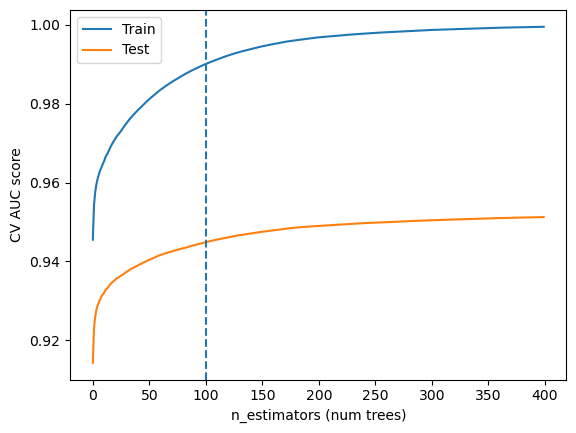

In [66]:
n_estimators = 100
fig, ax = plt.subplots()
ax.plot(score.index, score['train-auc-mean'], label='Train')
ax.plot(score.index, score['test-auc-mean'], label='Test')
ax.axvline(n_estimators, linestyle='--')
ax.legend()
ax.set_xlabel('n_estimators (num trees)')
ax.set_ylabel('CV AUC score')

In [67]:
model.set_params(n_estimators = n_estimators)
model.fit(trainX, trainY)

/mnt/ssd/miniconda3/envs/yba/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/mnt/ssd/miniconda3/envs/yba/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[19:49:20] WARNING: /croot/xgboost-split_1675119646044/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.03, max_delta_step=0,
              max_depth=20, min_child_weight=5, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=48,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.95,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [23]:
model.save_model(datapath+'../spock/models/spock.json')

In [63]:
model = XGBClassifier()
model.load_model(datapath+'../spock/models/spock.json')

# SPOCK

/mnt/ssd/miniconda3/envs/yba/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Text(0.5, 1.0, 'ROC curve (AUC = 0.912)')

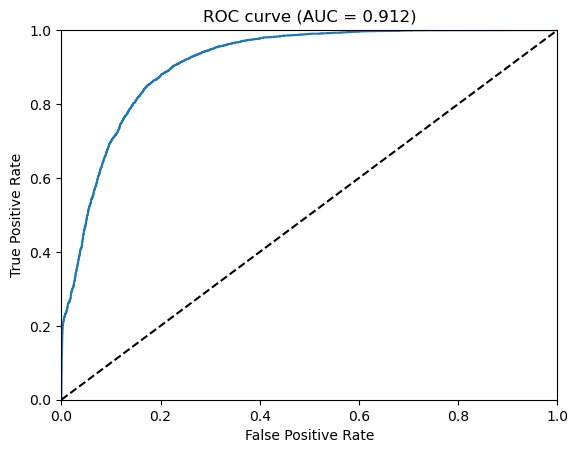

In [68]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(trainingdatafolder, model, features)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

In [15]:
stride = 10
np.savetxt('../spock/models/resROC.txt', (ROCthresholds[::stride], tpr[::stride], fpr[::stride]))

In [26]:
ROCthresholds, tpr, fpr = np.loadtxt('../spock/models/resROC.txt')
for i in range(0,len(tpr), 15):
    print("Threshold {0}, TPR = {1}, FPR = {2}".format(ROCthresholds[i], tpr[i], fpr[i]))

Threshold 1.9896588325500488, TPR = 0.0, FPR = 0.0
Threshold 0.8918883800506592, TPR = 0.2820996978851964, FPR = 0.004364555217366336
Threshold 0.8338184356689453, TPR = 0.408987915407855, FPR = 0.009245965657841842
Threshold 0.7911725640296936, TPR = 0.47658610271903323, FPR = 0.01418480445644059
Threshold 0.745854914188385, TPR = 0.5404078549848943, FPR = 0.019525641761902027
Threshold 0.705155074596405, TPR = 0.589690332326284, FPR = 0.025211049216102913
Threshold 0.6644747257232666, TPR = 0.6355740181268882, FPR = 0.031183598460920003
Threshold 0.6241954565048218, TPR = 0.6714501510574018, FPR = 0.03790271636133923
Threshold 0.5779088735580444, TPR = 0.7063821752265861, FPR = 0.044449549187388734
Threshold 0.5285456776618958, TPR = 0.7379154078549849, FPR = 0.05243209096651927
Threshold 0.48045119643211365, TPR = 0.771714501510574, FPR = 0.060931487968758975
Threshold 0.43897873163223267, TPR = 0.7938066465256798, FPR = 0.07184287601217482
Threshold 0.3960135579109192, TPR = 0.8164

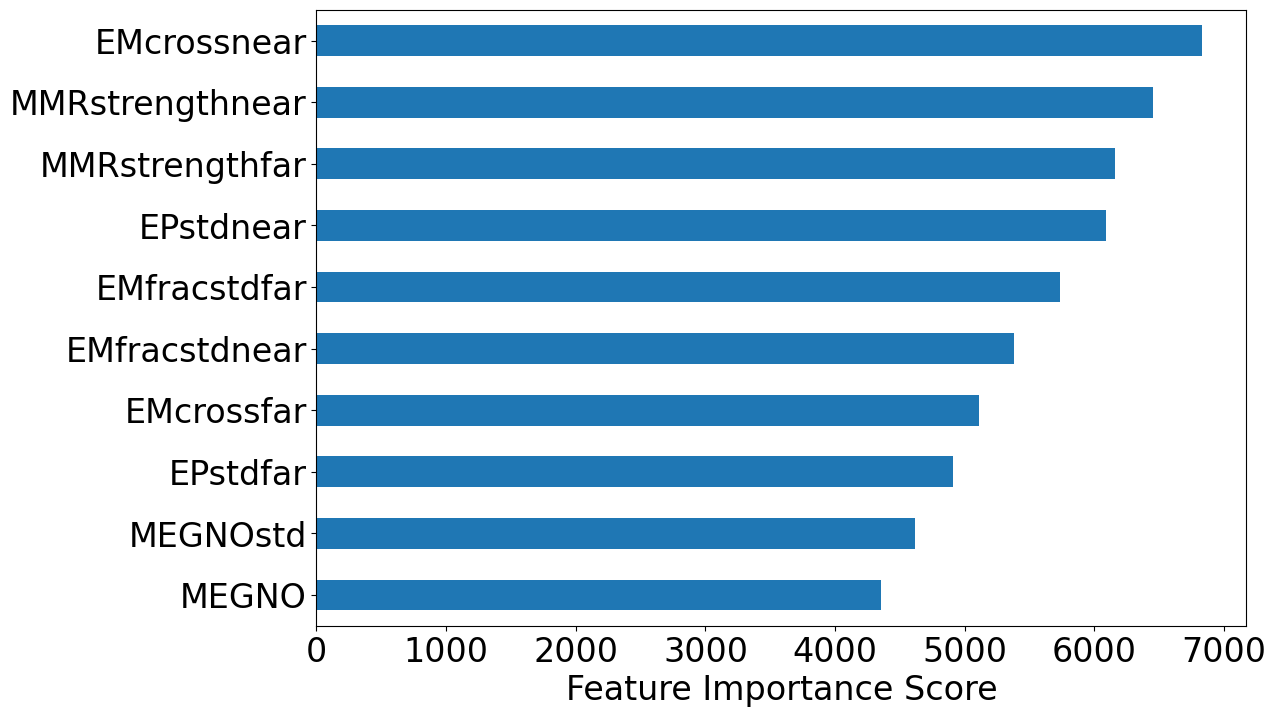

In [27]:
# feature importances
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
ax = feat_imp.plot.barh(figsize=(12,8), fontsize=24)
ax.set_xlabel('Feature Importance Score', fontsize=24)
ax.invert_yaxis()
plt.savefig('featureimportances.pdf', bbox_inches='tight')

In [28]:
feat_imp

EMcrossnear        6831.0
MMRstrengthnear    6448.0
MMRstrengthfar     6156.0
EPstdnear          6086.0
EMfracstdfar       5734.0
EMfracstdnear      5383.0
EMcrossfar         5108.0
EPstdfar           4911.0
MEGNOstd           4614.0
MEGNO              4352.0
dtype: float64

/mnt/ssd/miniconda3/envs/yba/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


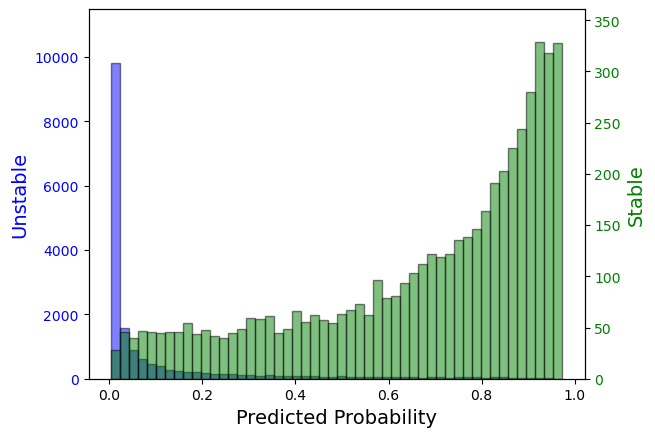

In [29]:
# Histogram:
bins = 50
Stable, Unstable = stable_unstable_hist(trainingdatafolder, model, features)

fig, ax1 = plt.subplots()
n, bins, patches = ax1.hist(Unstable, bins, alpha=0.5, label='No', color='blue', edgecolor = "black")
ax1.set_xlabel('Predicted Probability', fontsize=14)
ax1.set_ylabel('Unstable',  fontsize=14, color='blue')
for tl in ax1.get_yticklabels():
    tl.set_color('blue')
    
ax2 = ax1.twinx()
n, bins , patches = ax2.hist(Stable, bins, alpha=0.5, label='Yes',color='green', edgecolor = "black")
ax2.set_ylabel('Stable', fontsize=14, color='green')
for tl in ax2.get_yticklabels():
    tl.set_color('green')
       
ax1.set_ylim([0,35*n[-1]]) # goes up to ~4300
ax2.set_ylim([0,1.1*n[-1]]) # goes up to ~2100
fig.savefig('stable_unstable_comparison.png')

Text(0, 0.5, 'Fraction actually stable')

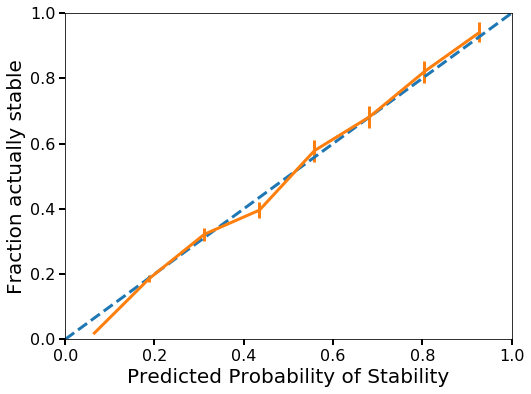

In [20]:
bincenters, fracstable, errorbars = calibration_plot(trainingdatafolder, model, features, bins=8)
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), '--')
ax.errorbar(bincenters, fracstable, errorbars)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xlabel('Predicted Probability of Stability')
ax.set_ylabel('Fraction actually stable')

/mnt/ssd/miniconda3/envs/yba/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Text(0.5, 1.0, 'Fraction of unstable systems mislabeled as stable')

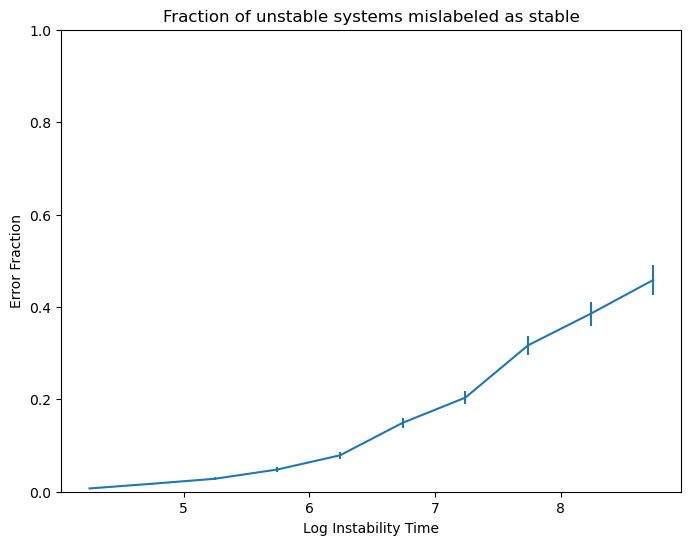

In [30]:
thresh = 0.34 # for 10% FPR
bincenters, errorfracs, errorbars = unstable_error_fraction(trainingdatafolder, model, thresh, features, bins=10)
fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(bincenters, errorfracs, errorbars)
ax.set_ylim([0,1])
ax.set_xlabel('Log Instability Time')
ax.set_ylabel('Error Fraction')
ax.set_title('Fraction of unstable systems mislabeled as stable')